<a href="https://colab.research.google.com/github/ParthikB/Neural-Style-Transfer/blob/master/neural_style_transfer_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import urllib
import numpy as np
import matplotlib.pyplot as plt
import cv2
# from google.colab.patches import cv2_imshow

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  running = 'GPU'
else:
  device = torch.device('cpu')
  running = 'CPU'
print(f'Running on : {running}')

Running on : GPU


In [0]:
'''
THIS IS WHAT I HAVE TO DO:

# 1) Get the VGG19 model.
# 2) Define the Content, Style and Total Loss Function, and also Gram Matrix.
# 3) Define a method to extract features from 'x' layer of the Network.
4) Create the Training Loop which will minimize the Total Loss function and update the values of the image.

'''

(400, 400, 3)


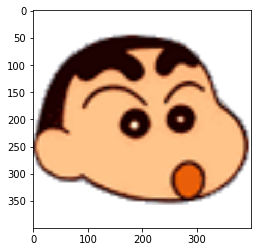

In [9]:
def urlToImage(url):
  resp = urllib.request.urlopen(url)
  img = np.asarray(bytearray(resp.read()), dtype='uint8')
  img = cv2.imdecode(img, cv2.IMREAD_COLOR)
  img2show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  img = np.expand_dims(img2show, axis=0)
  return img2show, img



url = 'https://pbs.twimg.com/profile_images/452516792426975232/rOQPTVq4_400x400.png'

img2show, img = urlToImage(url)

# Reshaping to remove the batch size dimension so that can be plotted
img2show = img2show.reshape(400, 400, -1)

# Reshaping to put the channels first as the torch network wants
img = np.rollaxis(img, 3, 1)
img = torch.tensor(img).float()
img.shape

# # A small program to find the correct values for np.rollaxis 
# for i in range(4):
#   for j in range(4):
#     new = np.rollaxis(img, i, j)
#     if new.shape == (1, 3, 400, 400):
#       print(i, j)
#       break

plt.imshow(img2show)
print(img2show.shape)

## Step 1 | Get Model

In [2]:
# Define the model
model = models.vgg19(pretrained=True)
print('Model Loaded!')

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 184MB/s]


Model Loaded!


## Step 2 | Define the Loss Functions

In [0]:
# Defining the Gram Matrix
def gram(x):
  pass # ---------------------------------------------------------------------------------------------- need to complete this


# Defining the Content Loss Function
def content_loss(contentFeatures, generatedFeatures):
  'contentFeatures, generatedFeatures --> tensors'
  loss = torch.mean((contentFeatures[0] - generatedFeatures[0])**2)
  return loss


# Defining the Style Loss Function
def style_loss(styleFeatures, generatedFeatures):
  'styleFeatures, generatedFeatures --> tensors'
  
  # Extracting the Gram matrix
  styleGram = gram(styleFeatures)

  loss = torch.mean((styleFeatures - generatedFeatures)**2)
  return loss


# Defining the Total Loss Function
def total_loss(loss_weights, generateImage, content_features, style_features):

  # Extracting the respective weights
  content_weight, style_weight = loss_weights

  # Extracting the generate image features from the model
  generate_outputs = get_generate_features(generateImage)

  # Splitting the generate Features into different categories
  generate_content_features = generate_outputs[0]
  generate_style_features   = generate_outputs[1:]

  # Initializing all costs with 0
  content_cost_value, style_cost_value = 0, 0

  # Defining partial weights
  # contentWeightPerLayer = 1.0 / float(numContentLayers)
  # styleWeightPerLayer = 1.0 / float(numStyleLayers)

  # Computing Content Cost
  content_cost_value += content_loss(content_features, generate_content_features)

  # Computing Style Cost for every layer
  # for i in range(len(style_features)):
  #   style_cost_value += style_loss(style_features[i], generate_style_features[i])
  

  # Assigning the weights
  content_cost_value *= content_weight
  # style_cost_value   *= style_weight

  # Computing the Total Loss
  # total_loss_value = content_cost_value + style_cost_value
  total_loss_value = content_cost_value

  # return total_loss_value, content_cost_value, style_cost_value
  return total_loss_value, content_cost_value


## Step 3 | Feature Extraction

In [0]:
def get_features(input_img, type_of_feature):
  '''
  >> A function that return the features of the 'input_img'.
  type_of_feature --> content/style
  '''

  if type_of_feature == 'content':
    layers = [12]
  else:
    layers = [2, 7, 14, 23, 32]
  
  outputs= []
  def hook(module, input, output):
      outputs.append(output)

  # Creating a dictionary containing the children of the layers
  features = {}
  for idx, layer_num in enumerate(layers):
    features['style_' + str(idx)] = list(model.children())[0][layer_num]

  # Hooking the network to get the output of every layer in the features dict.
  for i in range(len(layers)):
    features['style_' + str(i)].register_forward_hook(hook)
  
  # Passing the image through the network
  final_output_which_is_not_needed = model(input_img)
  
  # Returning the features
  return outputs



def get_generate_features(input_img):
  '''
  >> A function that returnes the content and style features of the 'input_img'.
  '''
  # Extracting the respective features
  content_features = get_features(input_img, 'content')
  style_features   = get_features(input_img, 'style')

  return content_features, style_features

In [0]:
# This is the layer of which the output is needed.
LAYER_NUM = 12

x = get_layer(model, LAYER_NUM)
x.shape

torch.Size([1, 256, 100, 100])

## Step 4 | Training Loop

In [0]:
def run_style_transfer(content_image, style_image, content_weight, style_weight, EPOCHS=1000):

  # Loading the VGG19 model
  model = models.vgg19(pretrained=True)
  print('Model Loaded!')

  # Extracting the content and style features
  content_features = get_features(content_image, 'content')
  style_features   = get_features(style_image  , 'style')

  # Creating the generate Image
  generate_image = content_image

  # Defining the optimizer
  optimizer = optim.Adam(model.parameters(), lr=5)

  # Storing the best Image and Loss
  best_loss, best_image = float('inf'), None

  # Zipping the Weights
  loss_weights = (content_weight, style_weight)

  for iter in range(EPOCHS):

    model.zero_grad()

    # Computing the outputs and thus, Total Loss
    totalLoss = total_loss(loss_weights, generate_image, content_features, style_features)

    print(totalLoss)
    break


  

In [30]:
run_style_transfer(img, img, 0.7, 0.4)

Model Loaded!
(tensor(0., grad_fn=<MulBackward0>), tensor(0., grad_fn=<MulBackward0>))
